In [1]:
from google.cloud import bigquery

bqclient = bigquery.Client.from_service_account_json("musa-509-75492c1cf2ae.json")

In [3]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import datashader as ds
import numpy as np

import datashader.transfer_functions as tf
import matplotlib.pyplot as plt

from datashader.bundling import connect_edges, hammer_bundle
from datashader.colors import inferno, viridis
from datashader.utils import export_image
from datashader.utils import lnglat_to_meters

from colorcet import palette
from matplotlib import cm

import cenpy
import imageio

acs = cenpy.remote.APIConnection("ACSDT5Y2018")
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 1-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census Current (2018) WMS

In [4]:
def get_edges(fips, month, cbgs):
    
    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("fips", "STRING", fips),
            bigquery.ScalarQueryParameter("month", "STRING", month),
        ]
    )
    
    query = f"""
        SELECT poi_cbg, home_cbg, sum(visits) as visits
        FROM (SELECT 
                lpad(CAST(poi_cbg AS STRING), 12, '0') as poi_cbg, 
                REGEXP_EXTRACT(unnested, '(.*?):') as home_cbg, 
                CAST(REGEXP_EXTRACT(unnested, ':(.*)') AS NUMERIC) as visits
              FROM `tidal-digit-291220.safegraph.2020_{month}`
              CROSS JOIN UNNEST(SPLIT(regexp_replace(REPLACE(REPLACE(visitor_home_cbgs, '{{', ''), '}}', ''), '\\"', ''))) as unnested
              WHERE SUBSTR(lpad(CAST(poi_cbg AS STRING), 12, '0'), 0, 5) = @fips AND visitor_home_cbgs != '{{}}')
        GROUP BY poi_cbg, home_cbg
            """
    
    resp = bqclient.query(query, job_config=job_config)
    data = resp.to_dataframe()
    
    edges = data.rename(columns={'poi_cbg': 'focal', 
                                 'home_cbg': 'target', 
                                 'visits': 'weight'})

    edges['focal'] = edges['focal'].astype('int64')
    edges['target'] = edges['target'].astype('int64')
    edges['weight'] = edges['weight'].astype('int64')

    edges = edges[edges['target'].isin(cbgs)]
    edges = edges[edges['weight']>10]
    
    return edges

In [5]:
def get_nodes(fips):
    
    state = fips[:2]
    county = fips[2:]
        
    where_clause = f"STATE = {state} AND COUNTY = {county}"
    block_groups = acs.mapservice.layers[10].query(where=where_clause)
    
    block_groups = block_groups.to_crs(3857)
    
    nodes = pd.DataFrame({'X': block_groups.centroid.x,
                          'Y': block_groups.centroid.y,
                          'cbg': block_groups.GEOID.astype('int64')}).set_index('cbg')
    
    return nodes

In [25]:
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09"]
FIPS = '42101'

In [26]:
nodes = get_nodes(FIPS)

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [28]:
edges = list()

for month in months:
        
        temp = get_edges(FIPS, month, nodes.index)
        temp['month'] = month
        
        edges.append(temp)

edges = pd.concat(edges, ignore_index=True)

In [93]:
density = []

for month in months:
    
    elist = edges[edges['month']==month]
    graph = nx.from_pandas_edgelist(elist, 'focal', 'target', ['weight'])
    
    density.append(nx.density(graph))

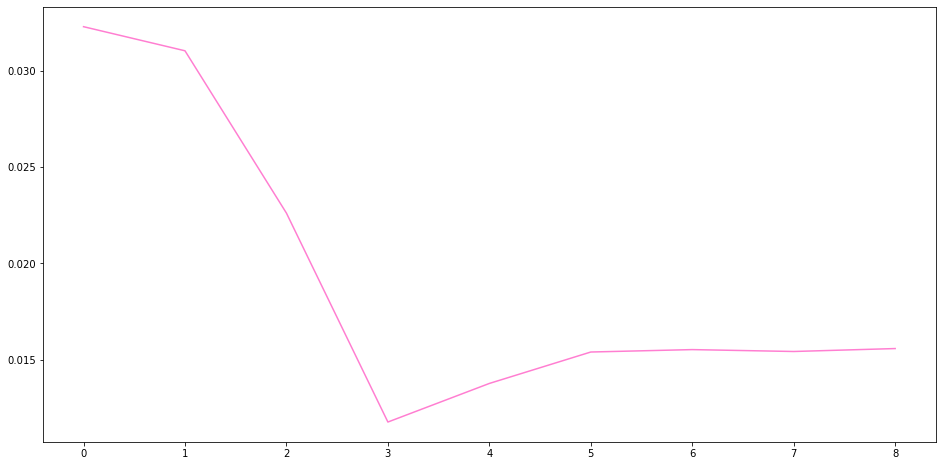

In [97]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(density, color=palette['glasbey_bw'][5])

In [114]:
all_fips = ['11001', '36061', '17031', '06037', '42101', '48201', '04013', '12086']

densities = list()

for fips in all_fips:
    
    density = []
    
    nlist = get_nodes(fips)
    
    for month in months:
        
        elist = get_edges(fips, month, nlist.index)
        graph = nx.from_pandas_edgelist(elist, 'focal', 'target', ['weight'])
        
        density.append(nx.density(graph))
        
    density = pd.DataFrame({'fips': fips,
                            'density': density})
    
    densities.append(density)
    
densities = pd.concat(densities, ignore_index=True)    

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' i

Text(0.5, 0.05, 'Density is defined as m / n (n - 1) where m is the number of edges and n is then number of nodes.')

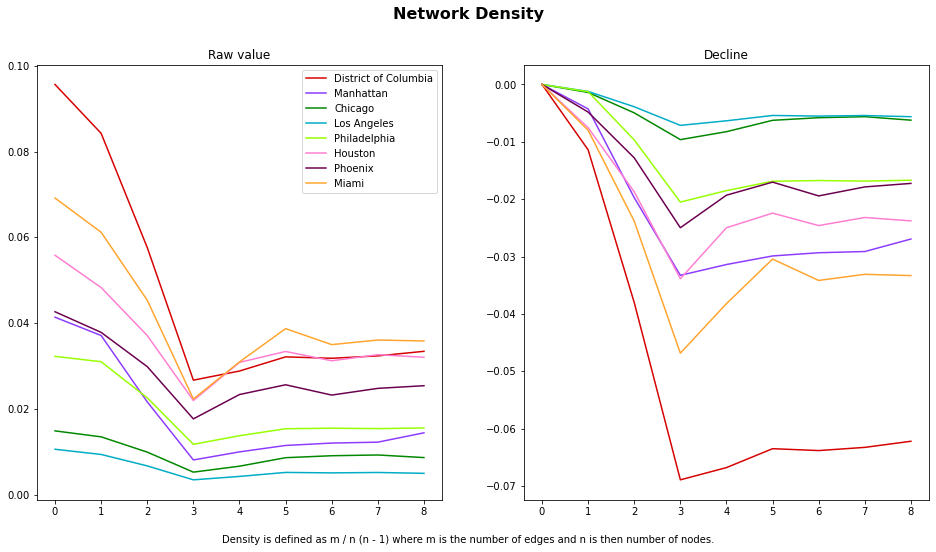

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for i in np.arange(0, len(densities.fips.unique())):
    
    fips = all_fips[i]
    labs = ['District of Columbia', 'Manhattan', 'Chicago', 'Los Angeles', 'Philadelphia', 'Houston', 'Phoenix', 'Miami']
    temp = densities[densities['fips']==fips].reset_index()
    
    axs[0].set_title('Raw value')
    axs[0].plot(temp.index, temp['density'], color=palette['glasbey_bw'][i], label=labs[i])

for i in np.arange(0, len(densities.fips.unique())):
    
    fips = all_fips[i]
    labs = ['District of Columbia', 'Manhattan', 'Chicago', 'Los Angeles', 'Philadelphia', 'Houston', 'Phoenix', 'Miami']
    temp = densities[densities['fips']==fips].reset_index()
    
    axs[1].set_title('Decline')
    axs[1].plot(temp.index, temp['density'] - temp['density'].max(), color=palette['glasbey_bw'][i], label=labs[i])
    
axs[0].legend()

fig.suptitle('Network Density', fontsize=16, weight='bold')
fig.text(0.5, 0.05, "Density is defined as m / n (n - 1) where m is the number of edges and n is then number of nodes.", ha='center')
